In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')

In [6]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        self.best_sse = 9999999

        init_cluster_column = np.zeros(X.shape[0], dtype=int).reshape(X.shape[0], 1)
        for n_init_iter in range(self.n_init):
            self.centers = X[np.random.choice(len(X),size=self.n_clusters, replace=False)]
            X_with_cluster = np.concatenate([X, init_cluster_column], 1)
            for i in range(self.max_iter):
                self._calc_sse(X_with_cluster)
                self._update_clusters(X_with_cluster)
                self._update_centers(X_with_cluster)
                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("{}回初期値を変更, {}回目: SSE: {}".format(n_init_iter, i, self.best_sse))
                # 全ての中心の移動距離の合計がtol以下であれば終了
                if self.total_move_distance < self.tol:
                    print("全ての中心の移動距離の合計が{}以下になったため終了".format(self.tol))
                    break

    def _calc_sse(self, X):
        _sse = 0
        for X_value in X:
            _sse += self._calc_distance(X_value[:-1], self.centers[int(X_value[-1])])

        if self.best_sse > _sse:
            self.best_centers = self.centers
            self.best_sse = _sse
    
    def _update_clusters(self, X):
        for X_index, X_value in enumerate(X):
            _nearest_value = 9999999
            for center_label, center in enumerate(self.centers):
                _distance = self._calc_distance(X_value[:-1], center)
                if _nearest_value > _distance:
                    _nearest_value = _distance
                    X[X_index, -1] = center_label

    def _update_centers(self, X):
        # この変数に各中心がどれだけ移動したか記録
        self.total_move_distance = 0
        for center_label, center in enumerate(self.centers):
            X_cluster_n = X[X[:, -1] == center_label]
            new_center_n = np.average(X_cluster_n[:,:-1], axis=0)
            self.total_move_distance += self._calc_distance(new_center_n, self.centers[center_label])
            self.centers[center_label] = new_center_n

    def _calc_distance(self, X_value, center):
#         return np.sqrt(((X_value - center) ** 2).sum())
        return np.linalg.norm(X_value - center)

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        pred_y = np.zeros(X.shape[0]).reshape(X.shape[0], 1)
        for X_index, X_value in enumerate(X):
            _nearest_value = 9999999
            for center_label, center in enumerate(self.centers):
                _distance = self._calc_distance(X_value, center)
                if _nearest_value > _distance:
                    _nearest_value = _distance
                    pred_y[X_index] = center_label

        return pred_y

def display_plot(X, model):
    pred_y = model.predict(X)
    pred_df = pd.DataFrame({'f0': X[:,0], 'f1': X[:,1], 'class': pred_y.T[0]})
    center_df = pd.DataFrame({'f0': km.best_centers[:,0], 'f1': km.best_centers[:,1], 'class': ["Center"] * len(km.best_centers)})
    df = pd.concat([pred_df, center_df])
    plt.figure(figsize=(5, 5))
    plt.xlim(-3,10)
    plt.ylim(-3,10)
    sns.scatterplot(x='f0', y='f1', hue='class', data=df)

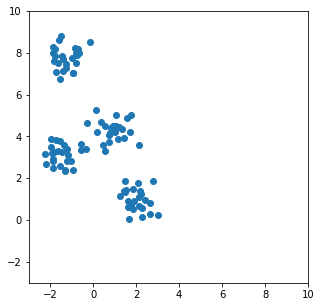

In [7]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)
plt.figure(figsize=(5, 5))
plt.xlim(-3,10)
plt.ylim(-3,10)
plt.scatter(X[:,0], X[:,1], label="data")

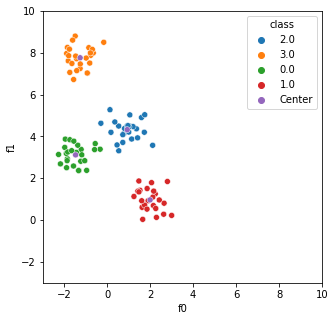

In [8]:
km = ScratchKMeans(4, 10, 100, 0, verbose=False)
km.fit(X)
display_plot(X, km)